# Importing the Libraries

In [118]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the sales Data

In [119]:

# Load the sales data
print("Loading sales data...")
df = pd.read_csv('sales_data.csv')
print("Sales data loaded successfully.")
print("DataFrame columns:", df.columns)


Loading sales data...
Sales data loaded successfully.
DataFrame columns: Index(['product_id', 'sales_year', 'sales_week of year',
       'sales_product_quantity'],
      dtype='object')


# Data Cleaing

In [120]:
# Data cleaning
print("Cleaning sales data...")
df.dropna(inplace=True)
df = df[(df != 0).all(axis=1)]
print("Sales data cleaned successfully.")
print("DataFrame shape after cleaning:", df.shape)
print("DataFrame columns after cleaning:", df.columns)

Cleaning sales data...
Sales data cleaned successfully.
DataFrame shape after cleaning: (11700, 4)
DataFrame columns after cleaning: Index(['product_id', 'sales_year', 'sales_week of year',
       'sales_product_quantity'],
      dtype='object')


# Calculate Average Sales 

In [121]:
# Calculate average sales
print("Calculating average sales...")
avg_sales = df.groupby(['product_id', 'sales_week of year'])['sales_product_quantity'].mean().reset_index()
avg_sales['sales_product_quantity'] = avg_sales['sales_product_quantity'].astype(float)
avg_sales['avg_sales_product_quantity'] = avg_sales['sales_product_quantity'].astype(int)
avg_sales = avg_sales.drop(columns=['sales_product_quantity'])
print(f"Average sales calculated {avg_sales.head()}")

Calculating average sales...
Average sales calculated    product_id  sales_week of year  avg_sales_product_quantity
0       242.0                 1.0                        6085
1       242.0                 2.0                        3778
2       242.0                 3.0                        5897
3       242.0                 4.0                        7325
4       242.0                 5.0                        6930


# Preparing Input and Output Data, Normalizing and Reshaping into 3D Array

In [122]:
# Prepare input and output data for the model
print("Preparing input and output data for the model...")
X = avg_sales[['product_id', 'sales_week of year']].values
y = avg_sales['avg_sales_product_quantity'].values

# Normalize features
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X)

# Reshape X to 3D array (samples, time steps, features)
X_normalized = X_normalized.reshape((X_normalized.shape[0], X_normalized.shape[1], 1))

Preparing input and output data for the model...


# Making Training and Testing Sets

In [123]:
# Split the data into training and testing sets
print("Splitting the data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
print(f"Data split into training and testing sets.")

Splitting the data into training and testing sets...
Data split into training and testing sets.


# Building the CNN Model

In [124]:
# Build the CNN model
print("Building the CNN model...")
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(input_layer)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1)(x)  # Output layer for regression

Building the CNN model...


# Creating and Compiling the model

In [22]:
# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
print("CNN model built.")

# Compile the model
print("Compiling the model...")
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
print("Model compiled.")

CNN model built.
Compiling the model...
Model compiled.


# Cross Validating the model - takes a Big Part

In [23]:
# Cross-validation
print("Performing cross-validation...")
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X_normalized):
    X_train_cv, X_test_cv = X_normalized[train_index], X_normalized[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]

    # Train the model
    history = model.fit(X_train_cv, y_train_cv, epochs=100, batch_size=32, validation_data=(X_test_cv, y_test_cv),
                        verbose=1)

    # Evaluate the model
    loss, mae = model.evaluate(X_test_cv, y_test_cv)
    print(f'Fold Mean Absolute Error: {mae}')

print("Cross-validation completed.")

Performing cross-validation...
Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 31720664.0000 - mae: 5516.6855 - val_loss: 31290832.0000 - val_mae: 5474.3447
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 30997856.0000 - mae: 5448.2363 - val_loss: 31075612.0000 - val_mae: 5454.6294
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 30923360.0000 - mae: 5442.3267 - val_loss: 30365942.0000 - val_mae: 5389.0908
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29580426.0000 - mae: 5317.1685 - val_loss: 28875398.0000 - val_mae: 5248.6729
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 27397082.0000 - mae: 5104.0845 - val_loss: 26430738.0000 - val_mae: 5009.5034
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 24367760.0000 - mae: 4800.0522 - val_loss: 23037828.0000 - val_mae: 4656.3413
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 20647884.0000 - mae: 4386.3535 - val_loss: 18927024.0000 - val_mae: 4186.7773
Epoch 8/1

# Train,Evaluate and Predict!!!

In [24]:
# Train the model on the full training data
print("Training the model...")
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
print("Model training completed.")

# Evaluate the model
print("Evaluating the model...")
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error: {mae}')

# Predicting and calculating R-squared
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


Training the model...
Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2199391.7500 - mae: 1207.1310 - val_loss: 1227265.7500 - val_mae: 903.4097
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2198848.0000 - mae: 1187.6411 - val_loss: 1239422.1250 - val_mae: 906.4920
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2196225.0000 - mae: 1190.8939 - val_loss: 1251376.2500 - val_mae: 910.1774
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2196467.0000 - mae: 1201.5413 - val_loss: 1247150.7500 - val_mae: 908.8549
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2087741.5000 - mae: 1162.7723 - val_loss: 1231201.6250 - val_mae: 904.1744
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2196558.0000 - mae: 1191.0048 - val_loss: 1241483.1250 - val_mae: 907.1191
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1999036.7500 - mae: 1153.8839 - val_loss: 1241059.3750 - val_mae: 906.9803
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 

# Saving the model

In [25]:

# Save the model
print("Saving the model...")
model.save('cnn_sales_model.keras')
print("Model saved.")

Saving the model...
Model saved.


# Load the model

In [141]:

# Load the model (if needed)
print("Loading the model...")
model = load_model('cnn_sales_model.keras')
print("Model loaded.")

Loading the model...
Model loaded.


# We have Trained our model , now onto Predicting the model

In [142]:
def model_predict(product_id, week, model):
    print(f"Predicting for product_id: {product_id}, week: {week}...")
    input_data = np.array([[product_id, week]])
    input_data = scaler_X.transform(input_data)  # Normalize input data
    input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
    prediction = model.predict(input_data)
    # Introduce random noise to simulate variability
    noise = np.random.normal(0, 0.1 * prediction[0][0])
    prediction_with_noise = prediction[0][0] + noise
    print(f"Prediction for product_id: {product_id}, week: {week}: {prediction_with_noise}")
    return prediction_with_noise

# Now onto Forcasting our model

In [143]:
def forecast_sales_for_product_rolling(product_id, start_week, product_price, model, n_weeks=52):
    print(f"Forecasting sales for product_id: {product_id} starting from week: {start_week}...")
    predictions = []
    current_week = start_week

    for _ in range(n_weeks):
        normalized_week = (current_week - 1) % 52 + 1
        prediction = model_predict(product_id, normalized_week, model)
        predictions.append(int(round(prediction)))
        current_week += 1

    forecast_df = pd.DataFrame({
        'product_id': [product_id] * n_weeks,
        'sales_week of year': np.arange(start_week, start_week + n_weeks) % 52 + 1,
        'forecasted_sales': predictions,
        'product_price': [int(round(product_price))] * n_weeks
    })

    print(f"Forecast for product_id: {product_id} completed.")
    return forecast_df

# now Directly we can put our Product ID, week and its Price for our model to run 

In [144]:
# Example usage
product_id = 14943  # Replace with the actual product_id you want to forecast
start_week = 1  # Replace with the actual starting sales_week of year
product_price = 17   # Replace with the actual product price

print(f"Generating sales forecast for product_id: {product_id}...")
forecast_df = forecast_sales_for_product_rolling(product_id, start_week, product_price, model)

# Save forecast DataFrame to CSV file
forecast_df.to_csv(f'sales_forecast_52_weeks_product_{product_id}.csv', index=False)
print(f"Forecast saved to sales_forecast_52_weeks_product_{product_id}.csv")

# Optionally, display the forecast DataFrame
print(forecast_df)

Generating sales forecast for product_id: 14943...
Forecasting sales for product_id: 14943 starting from week: 1...
Predicting for product_id: 14943, week: 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Prediction for product_id: 14943, week: 1: 6321.622862254701
Predicting for product_id: 14943, week: 2...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction for product_id: 14943, week: 2: 5079.022685240225
Predicting for product_id: 14943, week: 3...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction for product_id: 14943, week: 3: 4550.874167322265
Predicting for product_id: 14943, week: 4...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction for product_id: 14943, week: 4: 4547.145668367335
Predicting for product_id: 14943, week: 5...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prediction for product_id: 14943, week: 5: 5196.517320956215
Predicting for product_id: 14943, week: 6...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Prediction for product_id: 14943, week: 6: 5132.580781082412
Predicting for prod

## as the Product Price is same , we need to use the optimizer to give efficient pricing for our products

# now onto optimization!

### Where we use our Dynamic Pricing and our Optimizer 

In [145]:
def dynamic_price_interpolation(forecasted_sales, min_sales, max_sales, min_price, max_price):
    return min_price + (forecasted_sales - min_sales) * (max_price - min_price) / (max_sales - min_sales)


def optimize_prices(csv_file, model_file):
    print("Loading forecast data and model for optimization...")
    data = pd.read_csv(csv_file)
    print("Forecast data loaded. Columns:", data.columns)
    model = load_model(model_file)
    print("Model loaded.")

    columns = ["product_id", "sales_week of year", "forecasted_sales", "product_price", "dynamic_price"]
    optimization_results = pd.DataFrame(columns=columns)

    unique_products = data['product_id'].unique()

    for product_id in unique_products:
        product_data = data[data['product_id'] == product_id]
        min_sales = product_data['forecasted_sales'].min()
        max_sales = product_data['forecasted_sales'].max()
        cost = product_data.iloc[0]['product_price']
        min_price = cost - 0.15 * cost
        max_price = cost + 0.25 * cost

        for idx, row in product_data.iterrows():
            print(f"Optimizing price for product_id: {product_id}, week: {row['sales_week of year']}...")
            steady = row['forecasted_sales']

            # Calculate dynamic price using linear interpolation
            dynamic_price = dynamic_price_interpolation(steady, min_sales, max_sales, min_price, max_price)

            new_row = pd.DataFrame([{
                "product_id": product_id,
                "sales_week of year": row['sales_week of year'],
                "forecasted_sales": int(round(row['forecasted_sales'])),  # Convert forecasted_sales to integer
                "product_price": int(round(cost)),  # Convert product_price to integer
                "dynamic_price": dynamic_price
            }])

            optimization_results = pd.concat([optimization_results, new_row], ignore_index=True)
            print(
                f"Optimization for product_id: {product_id}, week: {row['sales_week of year']} completed. Dynamic price: {dynamic_price}")

    optimization_results.to_csv("optimization_results.csv", index=False)
    print("Optimization results saved to optimization_results.csv.")
    print(optimization_results)



# Lets give our product ID values and see optimized Prices 

In [146]:
# Example usage
csv_file = f"sales_forecast_52_weeks_product_{product_id}.csv"
model_file = "cnn_sales_model.keras"
optimize_prices(csv_file, model_file)

# Read the CSV file into a DataFrame
file_name = "optimization_results.csv"
df = pd.read_csv(file_name)

# Calculate sales values
df['sales_normal_price'] = df['forecasted_sales'] * df['product_price']
df['sales_dynamic_price'] = df['forecasted_sales'] * df['dynamic_price']

# Sum the sales values for the 52 weeks
total_sales_normal_price = df['sales_normal_price'].sum()
total_sales_dynamic_price = df['sales_dynamic_price'].sum()

# Print the total sales values
print(f"Total Sales with Normal Price: {total_sales_normal_price}")
print(f"Total Sales with Dynamic Price: {total_sales_dynamic_price}")


Loading forecast data and model for optimization...
Forecast data loaded. Columns: Index(['product_id', 'sales_week of year', 'forecasted_sales',
       'product_price'],
      dtype='object')
Model loaded.
Optimizing price for product_id: 14943, week: 2...
Optimization for product_id: 14943, week: 2 completed. Dynamic price: 20.495588792124195
Optimizing price for product_id: 14943, week: 3...
Optimization for product_id: 14943, week: 3 completed. Dynamic price: 17.295134418780766
Optimizing price for product_id: 14943, week: 4...
Optimization for product_id: 14943, week: 4 completed. Dynamic price: 15.935649375236652
Optimizing price for product_id: 14943, week: 5...
Optimization for product_id: 14943, week: 5 completed. Dynamic price: 15.925350246118894
Optimizing price for product_id: 14943, week: 6...
Optimization for product_id: 14943, week: 6 completed. Dynamic price: 17.59895872775464
Optimizing price for product_id: 14943, week: 7...
Optimization for product_id: 14943, week: 7

C:\Users\Owner\AppData\Local\Temp\ipykernel_15724\1157844175.py:40: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



# Some insights for above product which has dynamically priced

# Lets See some insights 
## to run in webserver use http://127.0.0.1:8050/

In [159]:
from dash import Dash, dcc, html
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# Load your DataFrame
df = pd.read_csv('optimization_results.csv')

# Check column names
print("Columns in DataFrame:", df.columns)

# Ensure required columns are present
required_columns = ['forecasted_sales', 'product_price', 'dynamic_price']
for column in required_columns:
    if column not in df.columns:
        raise KeyError(f"Column '{column}' is missing from the DataFrame")

# Add missing columns
df['sales_normal_price'] = df['forecasted_sales'] * df['product_price']
df['sales_dynamic_price'] = df['forecasted_sales'] * df['dynamic_price']

# Calculate totals for the bar plot
total_sales_normal_price = df['sales_normal_price'].sum()
total_sales_dynamic_price = df['sales_dynamic_price'].sum()

# Helper function to convert matplotlib figures to base64
def mpl_to_base64(fig):
    buf = BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

# Generate figures
# Total Sales Comparison Bar Graph
plt.figure(figsize=(8, 5))
plt.bar(['Normal Price Sales', 'Dynamic Price Sales'], [total_sales_normal_price, total_sales_dynamic_price], color=['blue', 'green'])
plt.xlabel('Pricing Type')
plt.ylabel('Total Sales')
plt.title('Total Sales Comparison: Normal Price vs. Dynamic Price')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
total_sales_bar_img = mpl_to_base64(plt.gcf())
plt.close()

# Sales with Normal and Dynamic Prices Line Plot
plt.figure(figsize=(10, 6))
plt.plot(df['sales_week of year'], df['sales_normal_price'], label='Sales with Normal Price', color='blue')
plt.plot(df['sales_week of year'], df['sales_dynamic_price'], label='Sales with Dynamic Price', linestyle='--', color='green')
plt.xlabel('Week of Year')
plt.ylabel('Sales')
plt.title('Sales with Normal Price vs. Dynamic Price')
plt.legend()
sales_line_plot_img = mpl_to_base64(plt.gcf())
plt.close()

# Box Plot of Product Prices
plt.figure(figsize=(10, 6))
box = df[['product_price', 'dynamic_price']].boxplot(color=dict(boxes='green', whiskers='green', caps='green', medians='red'))

# Extract median values for annotations
medians = {
    'product_price': df['product_price'].median(),
    'dynamic_price': df['dynamic_price'].median()
}

# Plotting markers for median values
for i, column in enumerate(['product_price', 'dynamic_price'], start=1):
    plt.scatter([i], [medians[column]], color='red', zorder=5)
    plt.annotate(f'Median: {medians[column]:.2f}', xy=(i, medians[column]), xytext=(i + 0.1, medians[column] + 0.5),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.title('Box Plot of Product Prices')
plt.ylabel('Price')
box_plot_img = mpl_to_base64(plt.gcf())
plt.close()

# 4-Quadrant Analysis
plt.figure(figsize=(12, 6))
plt.scatter(df['dynamic_price'], df['forecasted_sales'], alpha=0.5, c='green')
plt.axhline(y=df['forecasted_sales'].median(), color='blue', linestyle='--')
plt.axvline(x=df['dynamic_price'].median(), color='blue', linestyle='--')
plt.xlabel('Optimized Price')
plt.ylabel('Forecasted Sales')
plt.title('4-Quadrant Analysis of Optimized Price vs. Sales')
plt.grid(True, linestyle='--', alpha=0.7)
quadrant_analysis_img = mpl_to_base64(plt.gcf())
plt.close()

# Stacked Bar Plot of Optimized Prices by Week and Product
stacked_data = df.pivot_table(index='sales_week of year', columns='product_id', values='dynamic_price', aggfunc='mean')

plt.figure(figsize=(12, 8))
stacked_data.plot(kind='bar', stacked=True, color=['green', 'blue'])  # Adjust colors as needed
plt.title('Stacked Bar Plot of Optimized Prices by Week and Product')
plt.xlabel('Week of Year')
plt.ylabel('Optimized Price')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Product ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
stacked_bar_plot_img = mpl_to_base64(plt.gcf())
plt.close()

# Initialize the Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H1("Sales Data Visualizations"),
    
    html.Div([
        html.H2("Total Sales Comparison"),
        html.Img(src=f"data:image/png;base64,{total_sales_bar_img}"),
    ]),
    
    html.Div([
        html.H2("Sales with Normal Price vs. Dynamic Price"),
        html.Img(src=f"data:image/png;base64,{sales_line_plot_img}"),
    ]),
    
    html.Div([
        html.H2("Box Plot of Product Prices"),
        html.Img(src=f"data:image/png;base64,{box_plot_img}"),
    ]),
    
    html.Div([
        html.H2("4-Quadrant Analysis of Optimized Price vs. Sales"),
        html.Img(src=f"data:image/png;base64,{quadrant_analysis_img}"),
    ]),
    
    html.Div([
        html.H2("Stacked Bar Plot of Optimized Prices by Week and Product"),
        html.Img(src=f"data:image/png;base64,{stacked_bar_plot_img}"),
    ]),
])

if __name__ == '__main__':
    app.run_server(debug=True)


Columns in DataFrame: Index(['product_id', 'sales_week of year', 'forecasted_sales', 'product_price',
       'dynamic_price'],
      dtype='object')


<Figure size 1200x800 with 0 Axes>

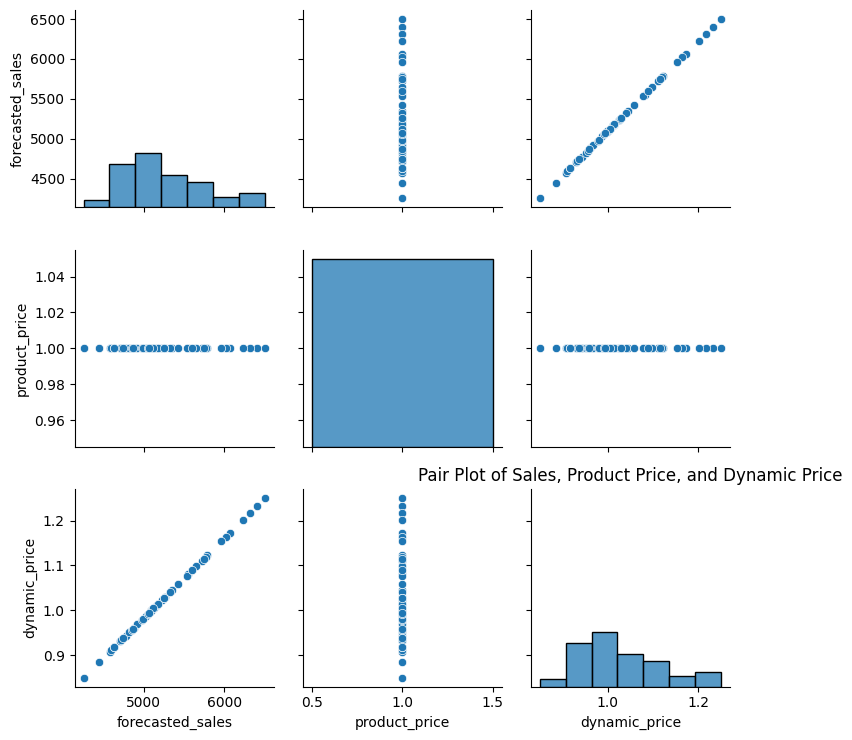

In [111]:
from math import pi

categories = ['forecasted_sales', 'product_price', 'dynamic_price']
num_vars = len(categories)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)

values = df[categories].mean().values.tolist()
values += values[:1]

ax.plot(angles, values, color='blue', linewidth=2, linestyle='solid')
ax.fill(angles, values, color='blue', alpha=0.25)
plt.title('Radar Chart of Average Sales and Prices')
plt.tight_layout()
radar_chart_img = mpl_to_base64(plt.gcf())
plt.S()


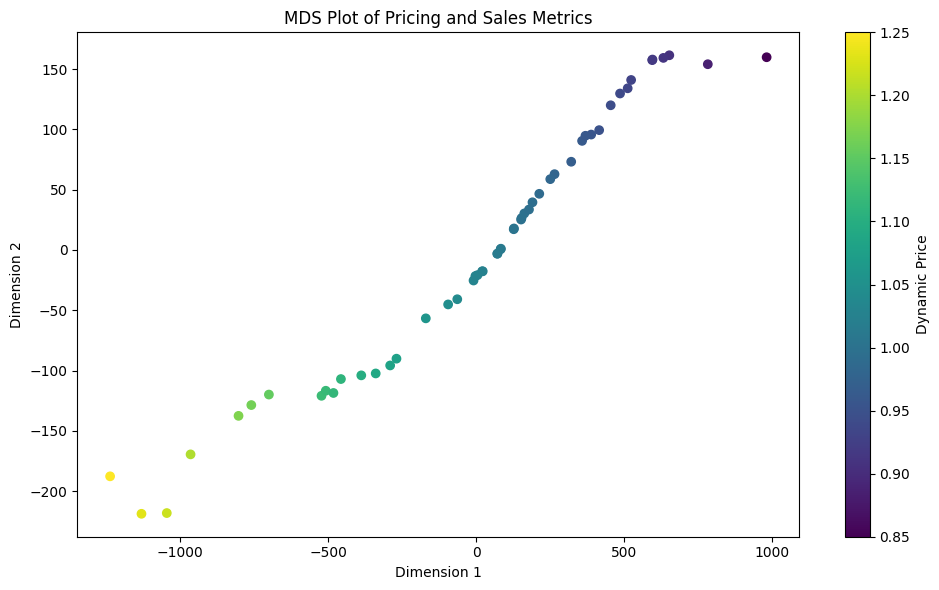

In [114]:
from sklearn.manifold import MDS

features = df[['forecasted_sales', 'product_price', 'dynamic_price']].values
mds = MDS(n_components=2, random_state=42)
reduced_features = mds.fit_transform(features)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['dynamic_price'], cmap='viridis')
plt.colorbar(label='Dynamic Price')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('MDS Plot of Pricing and Sales Metrics')
plt.tight_layout()
mds_plot_img = mpl_to_base64(plt.gcf())
plt.show()


In [1]:
!pip install nbconvert